The messages and their categories are in separate files which will need to be converted to a dataset which can be used for training a classification model. In this notebook, we build an ETL pipeline which merges the data, cleans it, and stores to an SQL database file.

This ETL pipeline is also automated in the script `data/process_data.py` (see project README).

## Load Datasets

In [2]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

In [3]:
# load messages dataset
messages = pd.read_csv('../data/disaster_messages.csv')
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [4]:
# load categories dataset
categories = pd.read_csv('../data/disaster_categories.csv')
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


## Merge datasets.


In [5]:
# merge datasets
df = pd.merge(left=messages, right=categories, left_on='id', right_on='id')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


##  Split `categories` into separate category columns.

In [6]:
# create a dataframe of the 36 individual category columns
categories = df['categories'].str.split(pat=';', expand=True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [7]:
# select the first row of the categories dataframe
row = categories.iloc[0]

# use this row to extract a list of new column names for categories.
category_colnames = row.apply(lambda x: x[:-2])
print(category_colnames)

0                    related
1                    request
2                      offer
3                aid_related
4               medical_help
5           medical_products
6          search_and_rescue
7                   security
8                   military
9                child_alone
10                     water
11                      food
12                   shelter
13                  clothing
14                     money
15            missing_people
16                  refugees
17                     death
18                 other_aid
19    infrastructure_related
20                 transport
21                 buildings
22               electricity
23                     tools
24                 hospitals
25                     shops
26               aid_centers
27      other_infrastructure
28           weather_related
29                    floods
30                     storm
31                      fire
32                earthquake
33                      cold
34            

In [8]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


## One-hot encode category values.

In [9]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].astype(str).str[-1]
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column])

In [10]:
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build final `df`

In [11]:
# drop the original categories column from `df`
df.drop('categories', axis=1, inplace=True)

df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [12]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26386 entries, 0 to 26385
Data columns (total 40 columns):
id                        26386 non-null int64
message                   26386 non-null object
original                  10246 non-null object
genre                     26386 non-null object
related                   26386 non-null int64
request                   26386 non-null int64
offer                     26386 non-null int64
aid_related               26386 non-null int64
medical_help              26386 non-null int64
medical_products          26386 non-null int64
search_and_rescue         26386 non-null int64
security                  26386 non-null int64
military                  26386 non-null int64
child_alone               26386 non-null int64
water                     26386 non-null int64
food                      26386 non-null int64
shelter                   26386 non-null int64
clothing                  26386 non-null int64
money                     26386 non-null i

## Clean

### Drop duplicates

In [14]:
# check number of duplicates
df.duplicated().sum()

170

In [15]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [16]:
# check number of duplicates
df.duplicated().sum()

0

### Check for null values

In [17]:
df.isna().sum()

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

Only the `original` column is missing values. We'll drop it since we're only interested in the `message` column (english translation) anyway.

In [18]:
# drop original column
df.drop('original', axis=1, inplace=True)

### Check category variables

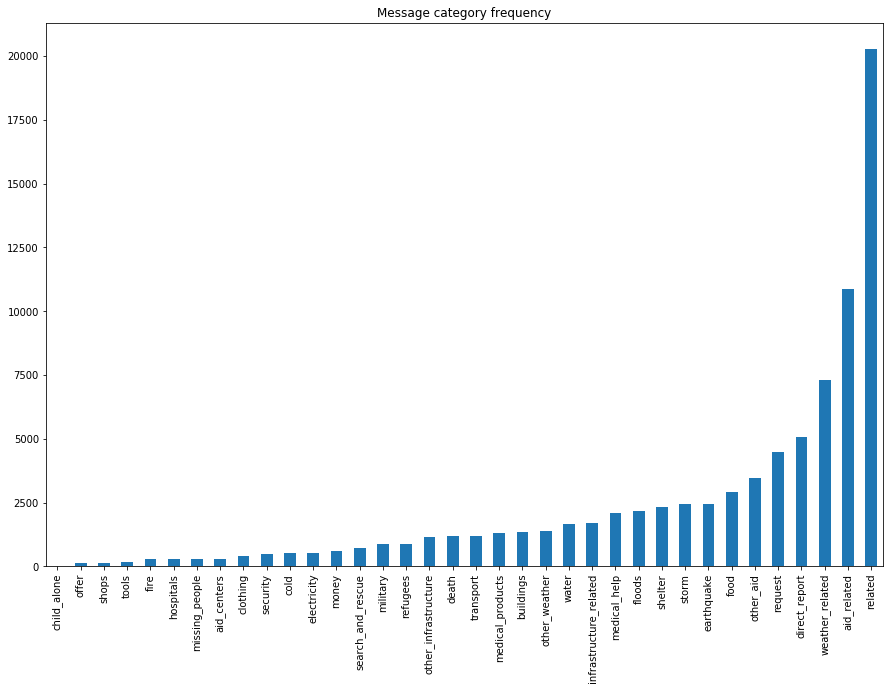

In [27]:
# plot distribution over all classes
category_names = df.columns.drop(['id', 'message', 'genre'])
df[category_names].sum().sort_values().plot.bar(figsize=(15, 10),
                                                title='Message category frequency');

In [18]:
def plot_categories(df, category_names):
    """Plot distributions of categories."""
    fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))
    for (i, category) in enumerate(category_names):
        df[category].value_counts().plot(kind='bar', ax=axs[i//6, i%6],
                                         title=category)  
    fig.tight_layout()

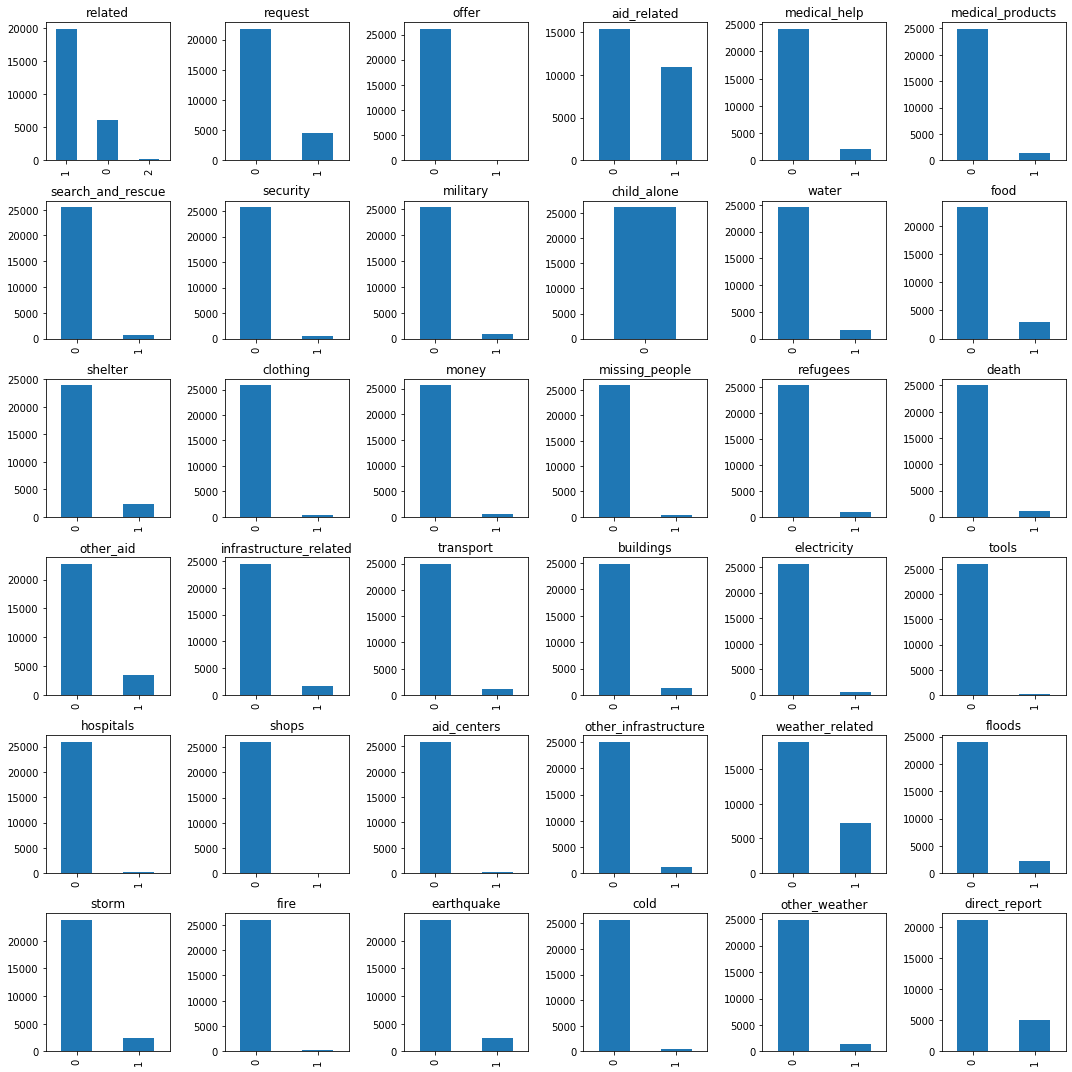

In [19]:
plot_categories(df, category_names)

These variables are mostly unbalanced, and several of these variables look problematic.

First, the category `child_alone` appears to have only one value

In [20]:
df['child_alone'].value_counts()

0    26216
Name: child_alone, dtype: int64

This variable is useless for prediction purposes, but we'll leave it in (a suitable classifier will predict 0 for this variable always).

The variable `related` has some entries with value 2. Let's inspect these

In [21]:
# check sum of other category values for related categories
df[category_names].groupby('related').sum().T

related,0,1,2
request,0,4474,0
offer,0,118,0
aid_related,0,10860,0
medical_help,0,2084,0
medical_products,0,1313,0
search_and_rescue,0,724,0
security,0,471,0
military,0,860,0
child_alone,0,0,0
water,0,1672,0


Based on this observation, and a comment in the [dataset description](https://appen.com/datasets/combined-disaster-response-data/), that "classes are noted in column titles with a simple binary 1= yes, 2=no.", we'll assume this is an encoding error and map `related` values 2 -> 0.

In [22]:
df['related'] = df['related'].apply(lambda x: 0 if x in [0, 2] else 1)

Finally, the distributions for `offer` and `shops` appear extremely imbalanced

In [23]:
df['offer'].value_counts()

0    26098
1      118
Name: offer, dtype: int64

In [24]:
df['shops'].value_counts()

0    26096
1      120
Name: shops, dtype: int64

Classifying these categories will likely prove to be a challenge.

## Save the clean dataset to sqlite database.


In [25]:
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df.to_sql('DisasterResponse', engine, if_exists='replace', index=False)